In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Skoda.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Citigo,Seri_Fabia,Seri_Favorit,...,Model_2.0 TDI RS,Model_2.5 TDI Elegance,Model_GLX,Model_LX,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,77500,-1.636364,-1.222222,-1.302885,1.273408,12.0,0.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,1559750,0.818182,-0.027778,0.197115,-1.146816,0.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,765000,0.545455,0.361111,0.182692,-0.037453,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,1059500,0.545455,0.500000,0.182692,-0.531835,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,875000,0.363636,0.222222,0.182692,-0.868914,0.0,0.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_1372\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,66581.605996,5.437357e+09,73738.433258,46729.676484


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:30:10,328] A new study created in memory with name: no-name-f9094609-83a0-4e74-83c9-29b507643524
[I 2023-05-23 21:30:10,522] Trial 1 finished with value: 671306.4401232651 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.00116729217627619, 'max_depth': 3, 'min_child_weight': 209}. Best is trial 1 with value: 671306.4401232651.
[I 2023-05-23 21:30:10,528] Trial 3 finished with value: 677038.8147400214 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.00017003931574201004, 'max_depth': 5, 'min_child_weight': 269}. Best is trial 1 with value: 671306.4401232651.
[I 2023-05-23 21:30:10,547] Trial 0 finished with value: 504657.12489078665 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.031863494924609506, 'max_depth': 9, 'min_child_weight': 44}. Best is trial 0 with value: 504657.12489078665.
[I 2023-05-23 21:30:10,562] Trial 4 finished with value: 667509.5068788693 and parameters: {'co

[I 2023-05-23 21:30:11,744] Trial 31 finished with value: 220518.68872939787 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.12985136162250757, 'max_depth': 12, 'min_child_weight': 68}. Best is trial 24 with value: 103475.28006646603.
[I 2023-05-23 21:30:11,758] Trial 30 finished with value: 186097.40768774456 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.14690903051668197, 'max_depth': 11, 'min_child_weight': 52}. Best is trial 24 with value: 103475.28006646603.
[I 2023-05-23 21:30:12,040] Trial 32 finished with value: 190726.46567248143 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.14874379142669275, 'max_depth': 15, 'min_child_weight': 73}. Best is trial 24 with value: 103475.28006646603.
[I 2023-05-23 21:30:12,096] Trial 33 finished with value: 185103.91211410644 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.158457171177494, 'max_depth': 8, 'min_child_we

[I 2023-05-23 21:30:13,501] Trial 63 finished with value: 367541.6815691217 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.35333044856567203, 'max_depth': 12, 'min_child_weight': 230}. Best is trial 49 with value: 81404.64427178467.
[I 2023-05-23 21:30:13,516] Trial 60 finished with value: 84830.62856866312 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.3065896066709942, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 49 with value: 81404.64427178467.
[I 2023-05-23 21:30:13,549] Trial 61 finished with value: 204802.363105344 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.3418009152054165, 'max_depth': 12, 'min_child_weight': 229}. Best is trial 49 with value: 81404.64427178467.
[I 2023-05-23 21:30:13,552] Trial 62 finished with value: 367544.50130918133 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.3311235280561296, 'max_depth': 12, 'min_child_weight':

[I 2023-05-23 21:30:15,424] Trial 90 finished with value: 95371.96069186651 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.4955354309392335, 'max_depth': 14, 'min_child_weight': 35}. Best is trial 80 with value: 79886.96586884654.
[I 2023-05-23 21:30:15,460] Trial 91 finished with value: 92041.15813461108 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.4938506115788151, 'max_depth': 14, 'min_child_weight': 33}. Best is trial 80 with value: 79886.96586884654.
[I 2023-05-23 21:30:15,501] Trial 92 finished with value: 84734.40004415828 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.4913624807963995, 'max_depth': 14, 'min_child_weight': 18}. Best is trial 80 with value: 79886.96586884654.
[I 2023-05-23 21:30:15,665] Trial 93 finished with value: 234950.1019985123 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.11780255474714936, 'max_depth': 15, 'min_child_weight': 

[I 2023-05-23 21:30:17,376] Trial 120 finished with value: 75546.7597047932 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.3743676662101446, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 116 with value: 74652.21640739476.
[I 2023-05-23 21:30:17,414] Trial 121 finished with value: 77711.85130276719 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.387619187082791, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 116 with value: 74652.21640739476.
[I 2023-05-23 21:30:17,469] Trial 122 finished with value: 76460.97720888654 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.3752780993629703, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 116 with value: 74652.21640739476.
[I 2023-05-23 21:30:17,498] Trial 123 finished with value: 79827.62438315303 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.378272277048281, 'max_depth': 12, 'min_child_weight': 

[I 2023-05-23 21:30:19,350] Trial 150 finished with value: 74054.60824057789 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.4314622674499, 'max_depth': 5, 'min_child_weight': 5}. Best is trial 147 with value: 73707.33009436168.
[I 2023-05-23 21:30:19,437] Trial 153 finished with value: 76011.77074686639 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.4494685864575349, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 147 with value: 73707.33009436168.
[I 2023-05-23 21:30:19,458] Trial 151 finished with value: 72096.95135150448 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.4836062274318667, 'max_depth': 5, 'min_child_weight': 7}. Best is trial 151 with value: 72096.95135150448.
[I 2023-05-23 21:30:19,495] Trial 152 finished with value: 77122.21805371533 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.472514042532922, 'max_depth': 5, 'min_child_weight': 7}. B

[I 2023-05-23 21:30:21,410] Trial 180 finished with value: 486623.3942659554 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.038492319206159344, 'max_depth': 5, 'min_child_weight': 262}. Best is trial 151 with value: 72096.95135150448.
[I 2023-05-23 21:30:21,488] Trial 181 finished with value: 539645.014128647 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.02465359958959701, 'max_depth': 5, 'min_child_weight': 15}. Best is trial 151 with value: 72096.95135150448.
[I 2023-05-23 21:30:21,582] Trial 182 finished with value: 89781.84772380025 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.29193771632894894, 'max_depth': 5, 'min_child_weight': 15}. Best is trial 151 with value: 72096.95135150448.
[I 2023-05-23 21:30:21,627] Trial 184 finished with value: 448528.20785000705 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.04460180598402978, 'max_depth': 5, 'min_child_w

[I 2023-05-23 21:30:23,550] Trial 211 finished with value: 77244.25792082281 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.42226940639127897, 'max_depth': 5, 'min_child_weight': 19}. Best is trial 151 with value: 72096.95135150448.
[I 2023-05-23 21:30:23,599] Trial 209 finished with value: 82288.89778126628 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.41121747092824124, 'max_depth': 5, 'min_child_weight': 22}. Best is trial 151 with value: 72096.95135150448.
[I 2023-05-23 21:30:23,706] Trial 212 finished with value: 94342.11603526653 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.49978002534462224, 'max_depth': 5, 'min_child_weight': 31}. Best is trial 151 with value: 72096.95135150448.
[I 2023-05-23 21:30:23,821] Trial 214 finished with value: 83377.67519943368 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.4997206222196679, 'max_depth': 5, 'min_child_weig

[I 2023-05-23 21:30:25,985] Trial 240 finished with value: 81965.48451307054 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.36533179086896755, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 239 with value: 72077.62474473835.
[I 2023-05-23 21:30:26,054] Trial 242 finished with value: 526980.9096297811 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.027845164846839198, 'max_depth': 5, 'min_child_weight': 95}. Best is trial 239 with value: 72077.62474473835.
[I 2023-05-23 21:30:26,055] Trial 241 finished with value: 100851.49838744207 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.2433247743750508, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 239 with value: 72077.62474473835.
[I 2023-05-23 21:30:26,093] Trial 243 finished with value: 103006.58114560938 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.22781706071831395, 'max_depth': 5, 'min_child_wei

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 72077.6247
Best params:
	colsample_bytree: 0.8
	subsample: 0.7
	learning_rate: 0.36994919072545795
	max_depth: 5
	min_child_weight: 1


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [5,9],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.8],
               'subsample': [0.7],
               'min_child_weight': [1]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.7}
{'TestDeger': 64642.15382020136, 'MSE': 5038211438.916359, 'RMSE': 70980.35952935403, 'MAE': 44269.553413519185}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9627036459848628

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.956111312224318

In [17]:
marka_model = joblib.dump(grid_final_model, "Skoda.pkl")

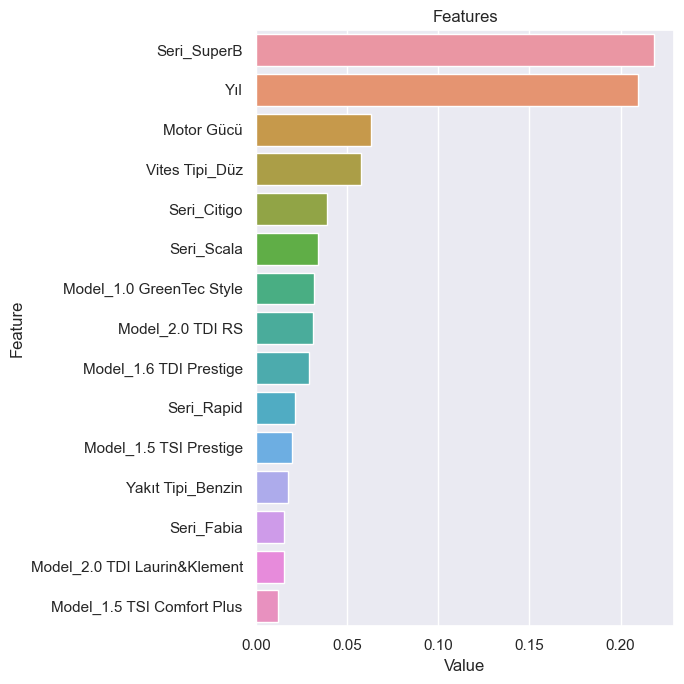

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)